# Correlation Coefficient - FRED® time series and stock prices from EOHD

At first we gather the relevant API keys and call the classes for downloading our data

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from eod import EodHistoricalData
import matplotlib.pyplot as plt
from datetime import datetime
from fredapi import Fred
import pandas as pd
import scipy
import os


start = '2020-01-01'
end = '2022-12-01'

stock_symbol = 'AAPL.US'  # https://eodhistoricaldata.com/financial-summary/AAPL.US
fred_indicator = 'RSXFS'  # Advance Retail Sales: Retail Trade (RSXFS) https://fred.stlouisfed.org/series/RSXFS

eod_key = os.environ['API_EOD']
fred_key = os.environ['API_FRED']

fred = Fred(api_key=fred_key)
client = EodHistoricalData(eod_key)

After downloading the stockprices we select the "adjusted close" column for clean data (https://eodhistoricaldata.com/financial-apis/adjusted-close-and-close-whats-the-difference/). Then we add Non-business days with the previous value recorded (e.g. the closing price of friday will equal our prices set for saturday and sunday).

In [2]:
# downloading the data
eod_data = client.get_prices_eod(stock_symbol, period='d', order='a', from_=start, to=end)

# selecting the adjusted close for our values and setting the "time"-column as our index
stock = pd.DataFrame(eod_data).set_index('date')['adjusted_close']
stock.index = pd.to_datetime(stock.index)

# adding the non-business days with privious value recorded
stock = stock.resample('d').asfreq().fillna(method='ffill')

Then we download the data from FRED® (https://fred.stlouisfed.org) and add like before days which were not recorded with the corresponding previous recorded value.

In [3]:
fred_data = fred.get_series(fred_indicator)[start : end]
indicator = fred_data.resample('1d').asfreq().fillna(method='ffill')

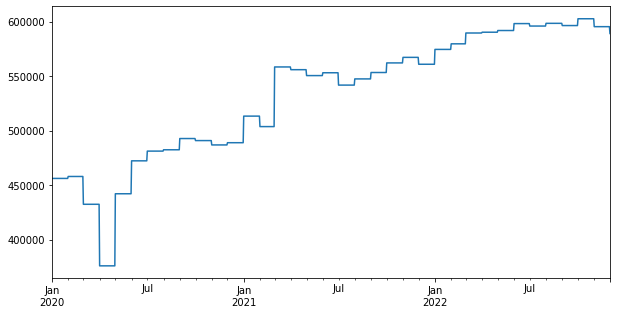

In [4]:
indicator.plot(figsize=(10, 5));

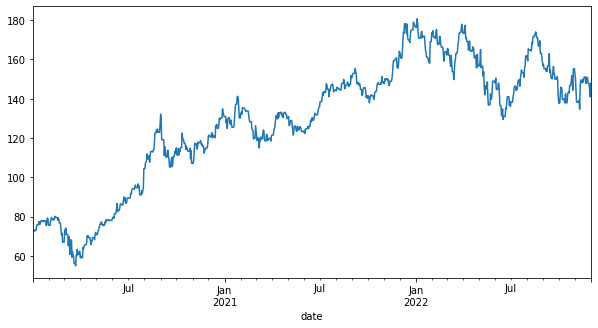

In [5]:
stock.plot(figsize=(10, 5));

In order to calculate the Pearson Correlation Coefficient both series must have the same length:

In [6]:
last_value = min(stock.index.max(), indicator.index.max())
first_value = max(stock.index.min(), indicator.index.min())

stock = stock[first_value : last_value]
indicator = indicator[first_value : last_value]
index= stock.index.to_list()[
    stock.index.to_list().index(first_value):
    stock.index.to_list().index(last_value)]

df_aggregated = pd.DataFrame({"stock": stock, "indicator": indicator}, index=index)

In the next step we remove the trend in the time series. And print the graphs of the decomposition for the stock prices.

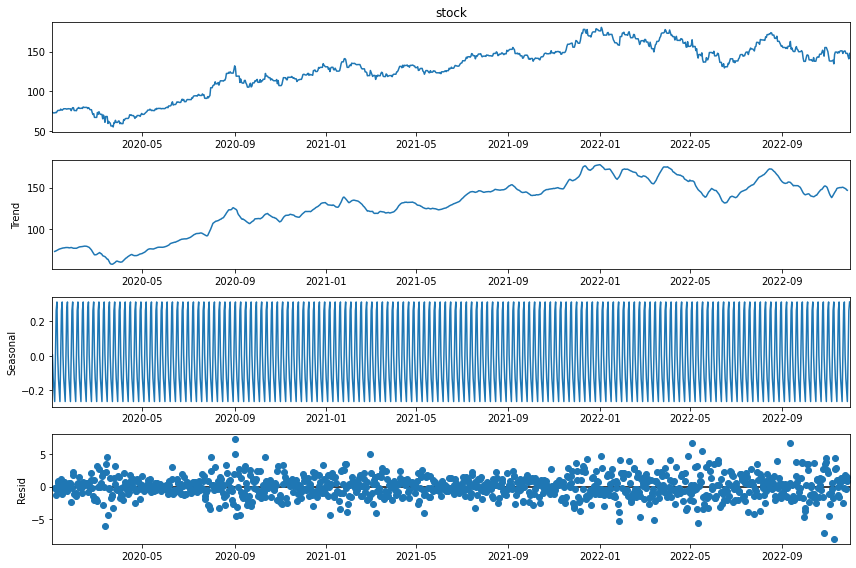

In [7]:
decomposed_stock = seasonal_decompose(df_aggregated["stock"].dropna())
decomposed_indicator = seasonal_decompose(df_aggregated["indicator"].dropna())

stock_resid = decomposed_stock.resid
indicator_resid = decomposed_indicator.resid

plt.rcParams['figure.figsize'] = (12, 8)

fig = decomposed_stock.plot();

In [8]:
print(scipy.stats.pearsonr(stock_resid.dropna(), indicator_resid.dropna()))

PearsonRResult(statistic=0.06451484342955038, pvalue=0.035889772166937464)
